In [1]:
# Input:
path_data = '../../01 data/train_pollution.csv'
n_lag = 3

path_01 = '../../03 outputs/multivariate/01/'
path_scaler = path_01 + 'time_scaler.pickle'
path_x_train = path_01 + 'X_train.npy'
path_y_train = path_01 + 'y_train.npy'
path_x_val = path_01 + 'X_val.npy'
path_y_val = path_01 + 'y_val.npy'
path_x_test = path_01 + 'X_test.npy'
path_y_test = path_01 + 'y_test.npy'

path_02 = '../../03 outputs/multivariate/02/'
path_forecaster_vanilla_lstm = path_02 + 'forecaster_vanilla_lstm.hdf5'
path_forecaster_stacked_lstm = path_02 + 'forecaster_stacked_lstm.hdf5'
path_forecaster_bidirectional_lstm = path_02 + 'forecaster_bidirectional_lstm.hdf5'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_absolute_error
import pickle
from keras.models import load_model

In [3]:
# Convert to datetime
def date_parser(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

# Load data
data = pd.read_csv(path_data)
data['date_time'] = data['date_time'].apply(date_parser)
data = data[
    ['target_carbon_monoxide', 'sensor_1', 'sensor_2', 'sensor_5', 'target_benzene', 'target_nitrogen_oxides']
]
data = data.loc[n_lag:, :]
print(data.shape)
data.head(3)

(7108, 6)


,target_carbon_monoxide,sensor_1,sensor_2,sensor_5,target_benzene,target_nitrogen_oxides
3,2.2,1321.0,929.0,1263.2,9.7,177.2
4,1.5,1272.0,852.7,1132.2,6.4,121.8
5,1.2,1220.9,697.5,949.0,4.4,88.1


In [4]:
# Load data (lag 3 steps)
X_train = np.load(open(path_x_train, 'rb'))
y_train = np.load(open(path_y_train, 'rb'))
X_val = np.load(open(path_x_val, 'rb'))
y_val = np.load(open(path_y_val, 'rb'))
X_test = np.load(open(path_x_test, 'rb'))
y_test = np.load(open(path_y_test, 'rb'))

In [6]:
# Load model and tokenizer
scaler = pickle.load(open(path_scaler, 'rb'))

forecaster_vanilla = load_model(path_forecaster_vanilla_lstm)
forecaster_stacked = load_model(path_forecaster_stacked_lstm)
forecaster_bidirectional = load_model(path_forecaster_bidirectional_lstm)

In [7]:
def invert_transform_pred(pred, X_):
    # Invert the prediction scaling
    n_features = X_.shape[2]
    inv_X = X_.reshape((X_.shape[0], X_.shape[1] * X_.shape[2]))
    inv_X = np.concatenate((pred, inv_X[:, -n_features+1:]), axis=1)
    inv_X = scaler.inverse_transform(inv_X)
    inv_pred = inv_X[:,0]

    #  Inverse the stationary function (if any)

    return inv_pred

# Vanilla LSTM

In [15]:
# Forecast train
pred_train_vanilla = forecaster_vanilla.predict(X_train, verbose=0)
pred_train_vanilla = invert_transform_pred(pred_train_vanilla, X_train)

# Forecast val
pred_val_vanilla = forecaster_vanilla.predict(X_val, verbose=0)
pred_val_vanilla = invert_transform_pred(pred_val_vanilla, X_val)

# Forecast test
pred_test_vanilla = forecaster_vanilla.predict(X_test, verbose=0)
pred_test_vanilla = invert_transform_pred(pred_test_vanilla, X_test)

In [24]:
# Combine predictions
pred_train_vanilla = pd.DataFrame(pred_train_vanilla, columns=['prediction'])
pred_train_vanilla['split'] = 'train'

pred_val_vanilla = pd.DataFrame(pred_val_vanilla, columns=['prediction'])
pred_val_vanilla['split'] = 'val'

pred_test_vanilla = pd.DataFrame(pred_test_vanilla, columns=['prediction'])
pred_test_vanilla['split'] = 'test'

pred_vanilla = pd.concat([pred_train_vanilla, pred_val_vanilla, pred_test_vanilla], axis=0).reset_index(drop=True)
pred_vanilla.index = pred_vanilla.index + n_lag

# Combine with original data
pred_vanilla = pd.concat([data['target_carbon_monoxide'], pred_vanilla], axis=1)
print(pred_vanilla.shape)
pred_vanilla.head(3)

(7108, 3)


,target_carbon_monoxide,prediction,split
3,2.2,2.133660,train
4,1.5,2.326510,train
5,1.2,1.848931,train


In [46]:
# Check the split boundary
train_split = pred_vanilla[pred_vanilla['split']=='train'].index[-1]
val_split = pred_vanilla[pred_vanilla['split']=='val'].index[-1]
print(train_split, val_split)

4622 5689


In [54]:
# Check the std of the train data
pred_vanilla[pred_vanilla['split']=='train']['target_carbon_monoxide'].std()

1.1920805922202546

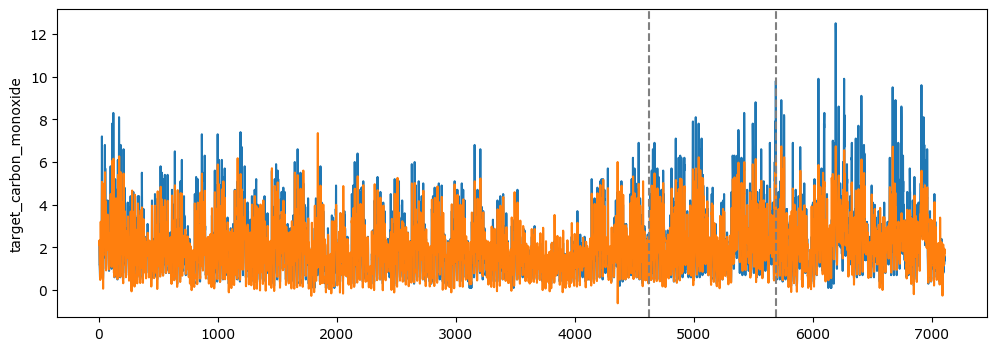

In [45]:
# Plot
plt.figure(figsize=(12,4))
sns.lineplot(pred_vanilla, x=pred_vanilla.index, y='target_carbon_monoxide')
sns.lineplot(pred_vanilla, x=pred_vanilla.index, y='prediction')
plt.axvline(train_split, linestyle='--', color='grey')
plt.axvline(val_split, linestyle='--', color='grey')
plt.show()

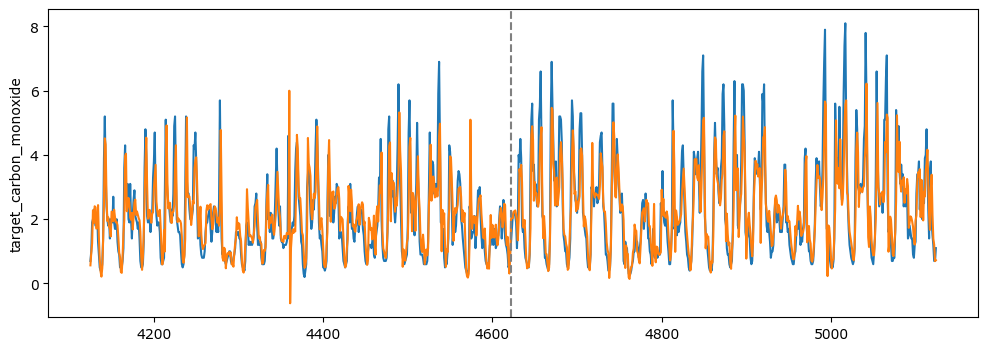

In [49]:
# Plot partial
plt.figure(figsize=(12,4))
sns.lineplot(pred_vanilla.iloc[train_split-500:train_split+500,:], x=pred_vanilla.iloc[train_split-500:train_split+500,:].index, y='target_carbon_monoxide')
sns.lineplot(pred_vanilla.iloc[train_split-500:train_split+500,:], x=pred_vanilla.iloc[train_split-500:train_split+500,:].index, y='prediction')
plt.axvline(train_split, linestyle='--', color='grey')
plt.show()

In [12]:
pred_vanilla = pd.read_csv('../../03 outputs/multivariate/03/prediction_vanilla_lstm.csv')

0.4553

In [20]:
# Accuracy
mae_train = round(mean_absolute_error(pred_vanilla.loc[pred_vanilla['split']=='train', 'target_carbon_monoxide'], pred_vanilla.loc[pred_vanilla['split']=='train', 'prediction']), 4)
mae_val = round(mean_absolute_error(pred_vanilla.loc[pred_vanilla['split']=='val', 'target_carbon_monoxide'], pred_vanilla.loc[pred_vanilla['split']=='val', 'prediction']), 4)
mae_test = round(mean_absolute_error(pred_vanilla.loc[pred_vanilla['split']=='test', 'target_carbon_monoxide'], pred_vanilla.loc[pred_vanilla['split']=='test', 'prediction']), 4)
print(f'training MAE: {mae_train}')
print(f'validation MAE: {mae_val}')
print(f'testing MAE: {mae_test}')

training MAE: 0.4553
validation MAE: 0.5909
testing MAE: 0.696


In [55]:
# Save
pred_vanilla.to_csv('../../03 outputs/multivariate/03/prediction_vanilla_lstm.csv')

# Stacked LSTM

In [7]:
# Forecast train
pred_train_stacked = forecaster_stacked.predict(X_train, verbose=0)
pred_train_stacked = invert_transform_pred(pred_train_stacked, X_train)

# Forecast val
pred_val_stacked = forecaster_stacked.predict(X_val, verbose=0)
pred_val_stacked = invert_transform_pred(pred_val_stacked, X_val)

# Forecast test
pred_test_stacked = forecaster_stacked.predict(X_test, verbose=0)
pred_test_stacked = invert_transform_pred(pred_test_stacked, X_test)

In [8]:
# Combine predictions
pred_train_stacked = pd.DataFrame(pred_train_stacked, columns=['prediction'])
pred_train_stacked['split'] = 'train'

pred_val_stacked = pd.DataFrame(pred_val_stacked, columns=['prediction'])
pred_val_stacked['split'] = 'val'

pred_test_stacked = pd.DataFrame(pred_test_stacked, columns=['prediction'])
pred_test_stacked['split'] = 'test'

pred_stacked = pd.concat([pred_train_stacked, pred_val_stacked, pred_test_stacked], axis=0).reset_index(drop=True)
pred_stacked.index = pred_stacked.index + n_lag

# Combine with original data
pred_stacked = pd.concat([data['target_carbon_monoxide'], pred_stacked], axis=1)
print(pred_stacked.shape)
pred_stacked.head(3)

(7108, 3)


,target_carbon_monoxide,prediction,split
3,2.2,2.253050,train
4,1.5,2.310955,train
5,1.2,2.069858,train


In [9]:
# Check the split boundary
train_split = pred_stacked[pred_stacked['split']=='train'].index[-1]
val_split = pred_stacked[pred_stacked['split']=='val'].index[-1]
print(train_split, val_split)

4622 5689


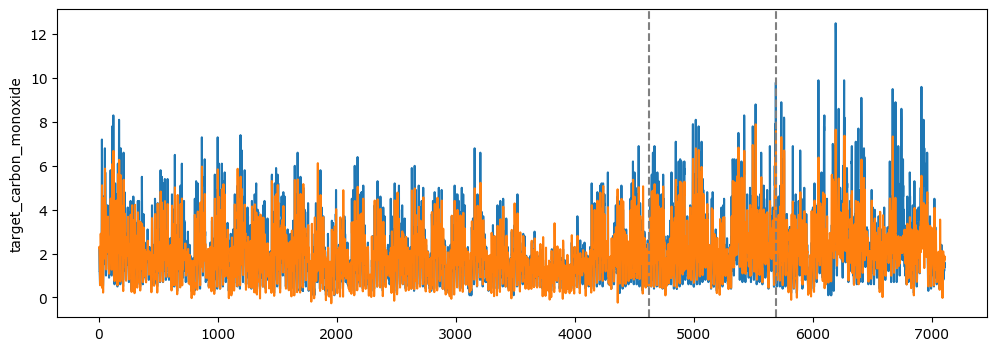

In [10]:
# Plot
plt.figure(figsize=(12,4))
sns.lineplot(pred_stacked, x=pred_stacked.index, y='target_carbon_monoxide')
sns.lineplot(pred_stacked, x=pred_stacked.index, y='prediction')
plt.axvline(train_split, linestyle='--', color='grey')
plt.axvline(val_split, linestyle='--', color='grey')
plt.show()

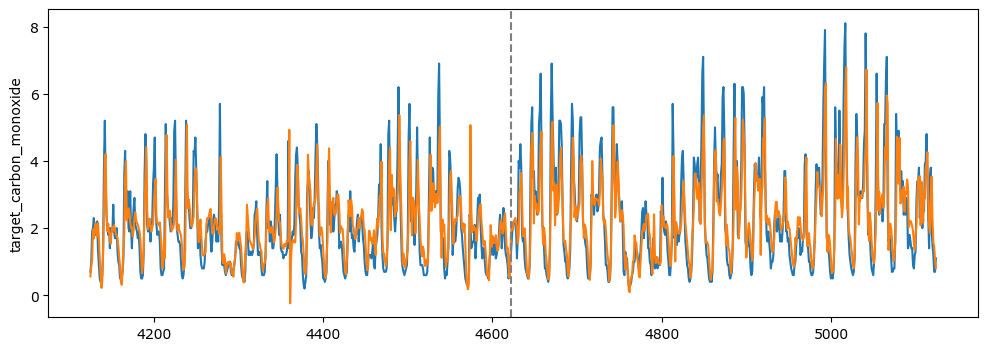

In [11]:
# Plot partial
plt.figure(figsize=(12,4))
sns.lineplot(pred_stacked.iloc[train_split-500:train_split+500,:], x=pred_stacked.iloc[train_split-500:train_split+500,:].index, y='target_carbon_monoxide')
sns.lineplot(pred_stacked.iloc[train_split-500:train_split+500,:], x=pred_stacked.iloc[train_split-500:train_split+500,:].index, y='prediction')
plt.axvline(train_split, linestyle='--', color='grey')
plt.show()

In [10]:
# Accuracy
mae_train = round(mean_absolute_error(pred_stacked.loc[pred_stacked['split']=='train', 'target_carbon_monoxide'], pred_stacked.loc[pred_stacked['split']=='train', 'prediction']), 4)
mae_val = round(mean_absolute_error(pred_stacked.loc[pred_stacked['split']=='val', 'target_carbon_monoxide'], pred_stacked.loc[pred_stacked['split']=='val', 'prediction']), 4)
mae_test = round(mean_absolute_error(pred_stacked.loc[pred_stacked['split']=='test', 'target_carbon_monoxide'], pred_stacked.loc[pred_stacked['split']=='test', 'prediction']), 4)
print(f'training MAE: {mae_train}')
print(f'validation MAE: {mae_val}')
print(f'testing MAE: {mae_test}')

training MAE: 0.4721
validation MAE: 0.613
testing MAE: 0.7737


In [11]:
# Save
pred_stacked.to_csv('../../03 outputs/multivariate/03/prediction_stacked_lstm.csv')

# Bidirectional LSTM

In [8]:
# Forecast train
pred_train_bidirectional = forecaster_bidirectional.predict(X_train, verbose=0)
pred_train_bidirectional = invert_transform_pred(pred_train_bidirectional, X_train)

# Forecast val
pred_val_bidirectional = forecaster_bidirectional.predict(X_val, verbose=0)
pred_val_bidirectional = invert_transform_pred(pred_val_bidirectional, X_val)

# Forecast test
pred_test_bidirectional = forecaster_bidirectional.predict(X_test, verbose=0)
pred_test_bidirectional = invert_transform_pred(pred_test_bidirectional, X_test)

In [9]:
# Combine predictions
pred_train_bidirectional = pd.DataFrame(pred_train_bidirectional, columns=['prediction'])
pred_train_bidirectional['split'] = 'train'

pred_val_bidirectional = pd.DataFrame(pred_val_bidirectional, columns=['prediction'])
pred_val_bidirectional['split'] = 'val'

pred_test_bidirectional = pd.DataFrame(pred_test_bidirectional, columns=['prediction'])
pred_test_bidirectional['split'] = 'test'

pred_bidirectional = pd.concat([pred_train_bidirectional, pred_val_bidirectional, pred_test_bidirectional], axis=0).reset_index(drop=True)
pred_bidirectional.index = pred_bidirectional.index + n_lag

# Combine with original data
pred_bidirectional = pd.concat([data['target_carbon_monoxide'], pred_bidirectional], axis=1)
print(pred_bidirectional.shape)
pred_bidirectional.head(3)

(7108, 3)


,target_carbon_monoxide,prediction,split
3,2.2,2.227771,train
4,1.5,2.296367,train
5,1.2,1.643141,train


In [11]:
# Check the split boundary
train_split = pred_bidirectional[pred_bidirectional['split']=='train'].index[-1]
val_split = pred_bidirectional[pred_bidirectional['split']=='val'].index[-1]
print(train_split, val_split)

4622 5689


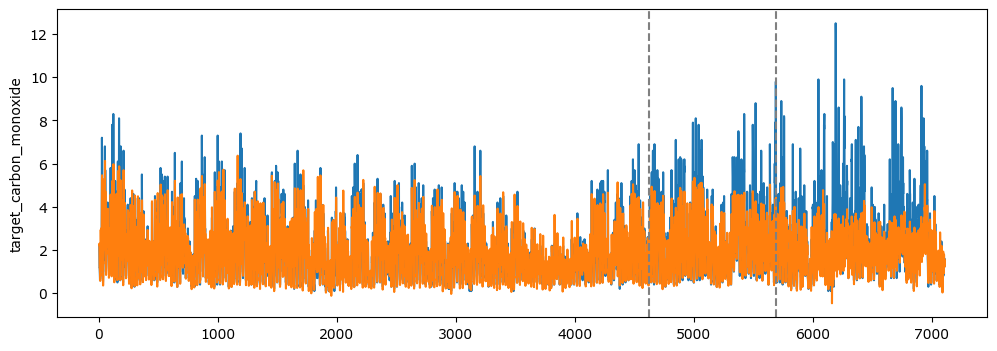

In [12]:
# Plot
plt.figure(figsize=(12,4))
sns.lineplot(pred_bidirectional, x=pred_bidirectional.index, y='target_carbon_monoxide')
sns.lineplot(pred_bidirectional, x=pred_bidirectional.index, y='prediction')
plt.axvline(train_split, linestyle='--', color='grey')
plt.axvline(val_split, linestyle='--', color='grey')
plt.show()

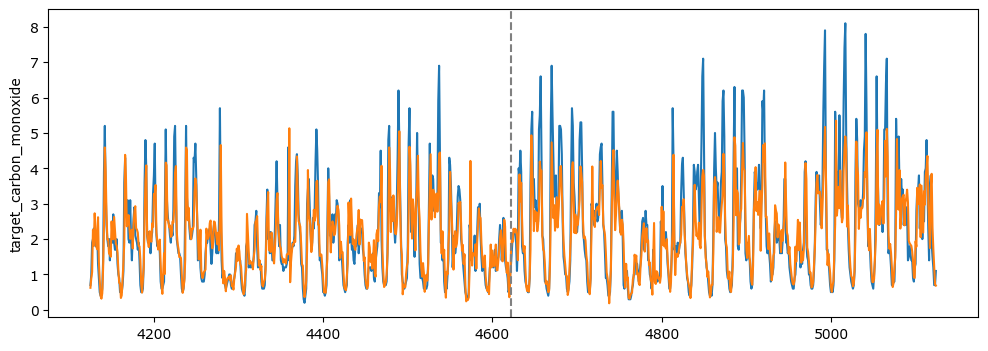

In [13]:
# Plot partial
plt.figure(figsize=(12,4))
sns.lineplot(pred_bidirectional.iloc[train_split-500:train_split+500,:], x=pred_bidirectional.iloc[train_split-500:train_split+500,:].index, y='target_carbon_monoxide')
sns.lineplot(pred_bidirectional.iloc[train_split-500:train_split+500,:], x=pred_bidirectional.iloc[train_split-500:train_split+500,:].index, y='prediction')
plt.axvline(train_split, linestyle='--', color='grey')
plt.show()

In [15]:
# Accuracy
mae_train = round(mean_absolute_error(pred_bidirectional.loc[pred_bidirectional['split']=='train', 'target_carbon_monoxide'], pred_bidirectional.loc[pred_bidirectional['split']=='train', 'prediction']), 4)
mae_val = round(mean_absolute_error(pred_bidirectional.loc[pred_bidirectional['split']=='val', 'target_carbon_monoxide'], pred_bidirectional.loc[pred_bidirectional['split']=='val', 'prediction']), 4)
mae_test = round(mean_absolute_error(pred_bidirectional.loc[pred_bidirectional['split']=='test', 'target_carbon_monoxide'], pred_bidirectional.loc[pred_bidirectional['split']=='test', 'prediction']), 4)
print(f'training MAE: {mae_train}')
print(f'validation MAE: {mae_val}')
print(f'testing MAE: {mae_test}')

training MAE: 0.4027
validation MAE: 0.6118
testing MAE: 0.9208


In [16]:
# Save
pred_bidirectional.to_csv('../../03 outputs/multivariate/03/prediction_bidirectional_lstm.csv')